In [1]:
# Adding needed libraries and reading data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.utils import shuffle

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [2]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### Checking for NAs

In [3]:
#Checking for missing data
NAs = pd.concat([train.isnull().sum(), test.isnull().sum()], axis=1, keys=['Train', 'Test'])
NAs[NAs.sum(axis=1) > 0]

,Train,Test
Alley,1369,1352.0
BsmtCond,37,45.0
BsmtExposure,38,44.0
BsmtFinSF1,0,1.0
BsmtFinSF2,0,1.0
BsmtFinType1,37,42.0
BsmtFinType2,38,42.0
BsmtFullBath,0,2.0
BsmtHalfBath,0,2.0
BsmtQual,37,44.0


### Importing my functions

In [4]:
# Prints R2 and RMSE scores
def get_score(prediction, lables):    
    print('R2: {}'.format(r2_score(prediction, lables)))
    print('RMSE: {}'.format(np.sqrt(mean_squared_error(prediction, lables))))

# Shows scores for train and validation sets    
def train_test(estimator, x_trn, x_tst, y_trn, y_tst):
    prediction_train = estimator.predict(x_trn)
    # Printing estimator
    print(estimator)
    # Printing train scores
    get_score(prediction_train, y_trn)
    prediction_test = estimator.predict(x_tst)
    # Printing test scores
    print("Test")
    get_score(prediction_test, y_tst)

### Splitting to features and labels and deleting variables I don't need

In [5]:
# Spliting to features and lables and deleting variable I don't need
train_labels = train.pop('SalePrice')

features = pd.concat([train, test], keys=['train', 'test'])

# I decided to get rid of features that have more than half of missing information or do not correlate to SalePrice
features.drop(['Utilities', 'RoofMatl', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'Heating', 'LowQualFinSF',
               'BsmtFullBath', 'BsmtHalfBath', 'Functional', 'GarageYrBlt', 'GarageArea', 'GarageCond', 'WoodDeckSF',
               'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC', 'Fence', 'MiscFeature', 'MiscVal'],
              axis=1, inplace=True)

### Filling NAs and converting features

In [6]:
# MSSubClass as str
features['MSSubClass'] = features['MSSubClass'].astype(str)

# MSZoning NA in pred. filling with most popular values
features['MSZoning'] = features['MSZoning'].fillna(features['MSZoning'].mode()[0])

# LotFrontage  NA in all. I suppose NA means 0
features['LotFrontage'] = features['LotFrontage'].fillna(features['LotFrontage'].mean())

# Alley  NA in all. NA means no access
features['Alley'] = features['Alley'].fillna('NOACCESS')

# Converting OverallCond to str
features.OverallCond = features.OverallCond.astype(str)

# MasVnrType NA in all. filling with most popular values
features['MasVnrType'] = features['MasVnrType'].fillna(features['MasVnrType'].mode()[0])

# BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2
# NA in all. NA means No basement
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    features[col] = features[col].fillna('NoBSMT')

# TotalBsmtSF  NA in pred. I suppose NA means 0
features['TotalBsmtSF'] = features['TotalBsmtSF'].fillna(0)

# Electrical NA in pred. filling with most popular values
features['Electrical'] = features['Electrical'].fillna(features['Electrical'].mode()[0])

# KitchenAbvGr to categorical
features['KitchenAbvGr'] = features['KitchenAbvGr'].astype(str)

# KitchenQual NA in pred. filling with most popular values
features['KitchenQual'] = features['KitchenQual'].fillna(features['KitchenQual'].mode()[0])

# FireplaceQu  NA in all. NA means No Fireplace
features['FireplaceQu'] = features['FireplaceQu'].fillna('NoFP')

# GarageType, GarageFinish, GarageQual  NA in all. NA means No Garage
for col in ('GarageType', 'GarageFinish', 'GarageQual'):
    features[col] = features[col].fillna('NoGRG')

# GarageCars  NA in pred. I suppose NA means 0
features['GarageCars'] = features['GarageCars'].fillna(0.0)

# SaleType NA in pred. filling with most popular values
features['SaleType'] = features['SaleType'].fillna(features['SaleType'].mode()[0])

# Year and Month to categorical
features['YrSold'] = features['YrSold'].astype(str)
features['MoSold'] = features['MoSold'].astype(str)

# Adding total sqfootage feature and removing Basement, 1st and 2nd floor features
features['TotalSF'] = features['TotalBsmtSF'] + features['1stFlrSF'] + features['2ndFlrSF']
features.drop(['TotalBsmtSF', '1stFlrSF', '2ndFlrSF'], axis=1, inplace=True)

In [7]:
## Log transformation of labels
train_labels = np.log(train_labels)

### Standardizing numeric data

In [8]:
## Standardizing numeric features
numeric_features = features.loc[:,['LotFrontage', 'LotArea', 'GrLivArea', 'TotalSF']]
numeric_features_standardized = (numeric_features - numeric_features.mean())/numeric_features.std()

### Converting categorical data to dummies

In [9]:
# Getting Dummies from Condition1 and Condition2
conditions = set([x for x in features['Condition1']] + [x for x in features['Condition2']])
dummies = pd.DataFrame(data=np.zeros((len(features.index), len(conditions))),
                       index=features.index, columns=conditions)
for i, cond in enumerate(zip(features['Condition1'], features['Condition2'])):
    dummies.ix[i, cond] = 1
features = pd.concat([features, dummies.add_prefix('Condition_')], axis=1)
features.drop(['Condition1', 'Condition2'], axis=1, inplace=True)

# Getting Dummies from Exterior1st and Exterior2nd
exteriors = set([x for x in features['Exterior1st']] + [x for x in features['Exterior2nd']])
dummies = pd.DataFrame(data=np.zeros((len(features.index), len(exteriors))),
                       index=features.index, columns=exteriors)
for i, ext in enumerate(zip(features['Exterior1st'], features['Exterior2nd'])):
    dummies.ix[i, ext] = 1
features = pd.concat([features, dummies.add_prefix('Exterior_')], axis=1)
features.drop(['Exterior1st', 'Exterior2nd', 'Exterior_nan'], axis=1, inplace=True)

# Getting Dummies from all other categorical vars
for col in features.dtypes[features.dtypes == 'object'].index:
    for_dummy = features.pop(col)
    features = pd.concat([features, pd.get_dummies(for_dummy, prefix=col)], axis=1)

### Obtaining standardized dataset

In [10]:
### Copying features
features_standardized = features.copy()

### Replacing numeric features by standardized values
features_standardized.update(numeric_features_standardized)

### Splitting train and test features

In [11]:
### Splitting features
train_features = features.loc['train'].drop('Id', axis=1).select_dtypes(include=[np.number]).values
test_features = features.loc['test'].drop('Id', axis=1).select_dtypes(include=[np.number]).values

### Splitting standardized features
train_features_st = features_standardized.loc['train'].drop('Id', axis=1).select_dtypes(include=[np.number]).values
test_features_st = features_standardized.loc['test'].drop('Id', axis=1).select_dtypes(include=[np.number]).values

### Splitting to train and validation sets

In [12]:
### Shuffling train sets
train_features_st, train_features, train_labels = shuffle(train_features_st, train_features, train_labels, random_state = 5)

In [13]:
### Splitting
x_train, x_test, y_train, y_test = train_test_split(train_features, train_labels, test_size=0.1, random_state=200)
x_train_st, x_test_st, y_train_st, y_test_st = train_test_split(train_features_st, train_labels, test_size=0.1, random_state=200)

### I'll be glad to hear suggestions on improving my models.


In [14]:
x_train.shape

(1314, 262)

In [15]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.wrappers.scikit_learn import KerasRegressor

# MODEL 1

In [16]:
model1 = Sequential()
model1.add(Dense(32, input_dim=x_train.shape[1], kernel_initializer='normal', activation='relu'))
model1.add(Dense(16, activation='relu'))
model1.add(Dense(1, activation='linear'))
model1.summary()
model1.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                8416      
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 8,961
Trainable params: 8,961
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.cast instead.


In [17]:
history1 = model1.fit(x_train, y_train, epochs=150, batch_size=32,  verbose=1, validation_split=0.2)

Train on 1051 samples, validate on 263 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/150
1051/1051 [==============================] - 2s 2ms/sample - loss: 51504.4833 - mean_squared_error: 51504.4844 - mean_absolute_error: 130.0167 - val_loss: 7048.8958 - val_mean_squared_error: 7048.8960 - val_mean_absolute_error: 44.7415
Epoch 2/150
1051/1051 [==============================] - 0s 223us/sample - loss: 2696.4468 - mean_squared_error: 2696.4470 - mean_absolute_error: 37.0204 - val_loss: 1008.2647 - val_mean_squared_error: 1008.2647 - val_mean_absolute_error: 21.1407
Epoch 3/150
1051/1051 [==============================] - 0s 241us/sample - loss: 690.5190 - mean_squared_error: 690.5191 - mean_absolute_error: 17.9322 - val_loss: 595.5785 - val_mean_squared_error: 595.5786 - val_mean_absolute_error: 15.1189
Epoch 4/150
1051/1051 [==============================] - 0s 223us/sample - loss: 274.9042 - mean_squared_error: 274.9042 - mean_absolute_error: 11.6985 - val_loss: 446

Epoch 34/150
1051/1051 [==============================] - 0s 91us/sample - loss: 6.5794 - mean_squared_error: 6.5794 - mean_absolute_error: 1.6317 - val_loss: 5.4571 - val_mean_squared_error: 5.4571 - val_mean_absolute_error: 1.5462
Epoch 35/150
1051/1051 [==============================] - 0s 93us/sample - loss: 6.9928 - mean_squared_error: 6.9928 - mean_absolute_error: 1.6558 - val_loss: 8.6776 - val_mean_squared_error: 8.6776 - val_mean_absolute_error: 1.6846
Epoch 36/150
1051/1051 [==============================] - 0s 88us/sample - loss: 6.8642 - mean_squared_error: 6.8642 - mean_absolute_error: 1.5573 - val_loss: 5.3592 - val_mean_squared_error: 5.3592 - val_mean_absolute_error: 1.4939
Epoch 37/150
1051/1051 [==============================] - 0s 109us/sample - loss: 11.9631 - mean_squared_error: 11.9631 - mean_absolute_error: 2.2292 - val_loss: 7.0525 - val_mean_squared_error: 7.0525 - val_mean_absolute_error: 1.6249
Epoch 38/150
1051/1051 [==============================] - 0s 89us

Epoch 69/150
1051/1051 [==============================] - 0s 86us/sample - loss: 36.3309 - mean_squared_error: 36.3309 - mean_absolute_error: 3.8971 - val_loss: 130.8344 - val_mean_squared_error: 130.8344 - val_mean_absolute_error: 3.3584
Epoch 70/150
1051/1051 [==============================] - 0s 80us/sample - loss: 32.8246 - mean_squared_error: 32.8246 - mean_absolute_error: 3.6629 - val_loss: 19.1777 - val_mean_squared_error: 19.1777 - val_mean_absolute_error: 1.7171
Epoch 71/150
1051/1051 [==============================] - 0s 82us/sample - loss: 40.3777 - mean_squared_error: 40.3777 - mean_absolute_error: 3.6076 - val_loss: 19.4044 - val_mean_squared_error: 19.4044 - val_mean_absolute_error: 2.2167
Epoch 72/150
1051/1051 [==============================] - 0s 129us/sample - loss: 53.1236 - mean_squared_error: 53.1236 - mean_absolute_error: 4.2567 - val_loss: 87.2423 - val_mean_squared_error: 87.2423 - val_mean_absolute_error: 4.9448
Epoch 73/150
1051/1051 [=========================

Epoch 104/150
1051/1051 [==============================] - 0s 87us/sample - loss: 3.1332 - mean_squared_error: 3.1332 - mean_absolute_error: 1.2709 - val_loss: 3.5868 - val_mean_squared_error: 3.5868 - val_mean_absolute_error: 1.6213
Epoch 105/150
1051/1051 [==============================] - 0s 87us/sample - loss: 1.2765 - mean_squared_error: 1.2765 - mean_absolute_error: 0.7962 - val_loss: 0.7092 - val_mean_squared_error: 0.7092 - val_mean_absolute_error: 0.5214
Epoch 106/150
1051/1051 [==============================] - 0s 91us/sample - loss: 1.5333 - mean_squared_error: 1.5333 - mean_absolute_error: 0.8788 - val_loss: 0.8138 - val_mean_squared_error: 0.8138 - val_mean_absolute_error: 0.5552
Epoch 107/150
1051/1051 [==============================] - 0s 97us/sample - loss: 1.4820 - mean_squared_error: 1.4820 - mean_absolute_error: 0.8295 - val_loss: 3.1267 - val_mean_squared_error: 3.1267 - val_mean_absolute_error: 0.9808
Epoch 108/150
1051/1051 [==============================] - 0s 83

Epoch 139/150
1051/1051 [==============================] - 0s 84us/sample - loss: 5.2313 - mean_squared_error: 5.2313 - mean_absolute_error: 1.5465 - val_loss: 42.0721 - val_mean_squared_error: 42.0721 - val_mean_absolute_error: 4.5273
Epoch 140/150
1051/1051 [==============================] - 0s 94us/sample - loss: 63.0564 - mean_squared_error: 63.0564 - mean_absolute_error: 5.0415 - val_loss: 145.9879 - val_mean_squared_error: 145.9879 - val_mean_absolute_error: 3.6473
Epoch 141/150
1051/1051 [==============================] - 0s 80us/sample - loss: 184.9490 - mean_squared_error: 184.9490 - mean_absolute_error: 8.9051 - val_loss: 2734.5057 - val_mean_squared_error: 2734.5056 - val_mean_absolute_error: 14.9364
Epoch 142/150
1051/1051 [==============================] - 0s 81us/sample - loss: 247.7653 - mean_squared_error: 247.7653 - mean_absolute_error: 9.9454 - val_loss: 514.7057 - val_mean_squared_error: 514.7057 - val_mean_absolute_error: 16.6160
Epoch 143/150
1051/1051 [===========

dict_keys(['loss', 'mean_squared_error', 'mean_absolute_error', 'val_loss', 'val_mean_squared_error', 'val_mean_absolute_error'])


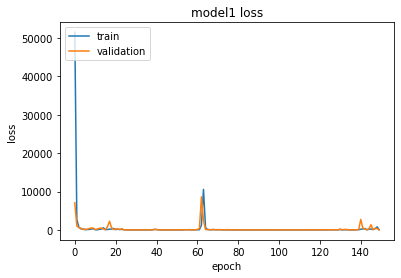

In [18]:
print(history1.history.keys())
# "Loss"
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('model1 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [19]:
ypred1=model1.predict(x_test)

In [20]:
y_testarr=np.array(y_test.values)

In [21]:
ypredarr1=np.array(ypred1)

In [22]:
y_testarr=y_testarr.reshape(146,)

In [23]:
ypredarr1=ypredarr1.reshape(146,)

In [24]:
error=0
for i in range(0,len(ypredarr1)):
    error+=abs((y_testarr[i]-ypredarr1[i])/y_testarr[i]) * 100
error=error/146
print("accuracy=",100-error)

accuracy= 76.99630073711221


In [25]:
error =  np.abs(y_test - ypredarr1)
mean_error = np.mean(error)
min_error = np.min(error)
max_error = np.max(error)
std_error = np.std(error)

In [26]:
print("mean error=",mean_error)

mean error= 2.7765465716040407


# MODEL 2

In [27]:
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(32, input_dim=x_train.shape[1], kernel_initializer='normal', activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss='mean_squared_error', optimizer='adam',metrics=['mse','mae'])
    model.summary()
    return model

In [28]:
estimator = KerasRegressor(build_fn=baseline_model, epochs=150, batch_size=32,  verbose=1,validation_split=0.2)

In [29]:
history2 = estimator.fit(x_train, y_train)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 32)                8416      
_________________________________________________________________
dense_4 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 8,961
Trainable params: 8,961
Non-trainable params: 0
_________________________________________________________________
Train on 1051 samples, validate on 263 samples
Epoch 1/150
1051/1051 [==============================] - 2s 2ms/sample - loss: 32.1274 - mean_squared_error: 32.1274 - mean_absolute_error: 2.6423 - val_loss: 5.0286 - val_mean_squared_error: 5.0286 - val_mean_absolute_error: 1.6002
Epoch 2/150
1051/1051 [==============================] - 0s 229us/sample - loss: 1.9801 - mean_squared_error: 1.9801 - mean_

1051/1051 [==============================] - 0s 112us/sample - loss: 1.4618 - mean_squared_error: 1.4618 - mean_absolute_error: 0.8106 - val_loss: 8.4581 - val_mean_squared_error: 8.4581 - val_mean_absolute_error: 1.5240
Epoch 33/150
1051/1051 [==============================] - 0s 110us/sample - loss: 1.3379 - mean_squared_error: 1.3379 - mean_absolute_error: 0.8091 - val_loss: 0.7787 - val_mean_squared_error: 0.7787 - val_mean_absolute_error: 0.6643
Epoch 34/150
1051/1051 [==============================] - 0s 129us/sample - loss: 0.3419 - mean_squared_error: 0.3419 - mean_absolute_error: 0.4280 - val_loss: 0.3835 - val_mean_squared_error: 0.3835 - val_mean_absolute_error: 0.5562
Epoch 35/150
1051/1051 [==============================] - 0s 103us/sample - loss: 0.5705 - mean_squared_error: 0.5705 - mean_absolute_error: 0.5677 - val_loss: 0.6371 - val_mean_squared_error: 0.6371 - val_mean_absolute_error: 0.6256
Epoch 36/150
1051/1051 [==============================] - 0s 90us/sample - lo

1051/1051 [==============================] - 0s 89us/sample - loss: 0.8689 - mean_squared_error: 0.8689 - mean_absolute_error: 0.6871 - val_loss: 1.9933 - val_mean_squared_error: 1.9933 - val_mean_absolute_error: 1.0114
Epoch 68/150
1051/1051 [==============================] - 0s 91us/sample - loss: 0.5917 - mean_squared_error: 0.5917 - mean_absolute_error: 0.4986 - val_loss: 0.6292 - val_mean_squared_error: 0.6292 - val_mean_absolute_error: 0.2916
Epoch 69/150
1051/1051 [==============================] - 0s 82us/sample - loss: 0.1063 - mean_squared_error: 0.1063 - mean_absolute_error: 0.2312 - val_loss: 0.1765 - val_mean_squared_error: 0.1765 - val_mean_absolute_error: 0.2850
Epoch 70/150
1051/1051 [==============================] - 0s 96us/sample - loss: 0.6040 - mean_squared_error: 0.6040 - mean_absolute_error: 0.5585 - val_loss: 0.8890 - val_mean_squared_error: 0.8890 - val_mean_absolute_error: 0.3664
Epoch 71/150
1051/1051 [==============================] - 0s 82us/sample - loss: 

1051/1051 [==============================] - 0s 85us/sample - loss: 0.0413 - mean_squared_error: 0.0413 - mean_absolute_error: 0.1498 - val_loss: 0.1022 - val_mean_squared_error: 0.1022 - val_mean_absolute_error: 0.2523
Epoch 103/150
1051/1051 [==============================] - 0s 90us/sample - loss: 0.1719 - mean_squared_error: 0.1719 - mean_absolute_error: 0.2940 - val_loss: 1.1713 - val_mean_squared_error: 1.1713 - val_mean_absolute_error: 0.3847
Epoch 104/150
1051/1051 [==============================] - 0s 79us/sample - loss: 0.7465 - mean_squared_error: 0.7465 - mean_absolute_error: 0.6312 - val_loss: 0.4400 - val_mean_squared_error: 0.4400 - val_mean_absolute_error: 0.4942
Epoch 105/150
1051/1051 [==============================] - 0s 101us/sample - loss: 1.5965 - mean_squared_error: 1.5965 - mean_absolute_error: 0.6859 - val_loss: 2.6557 - val_mean_squared_error: 2.6557 - val_mean_absolute_error: 1.4322
Epoch 106/150
1051/1051 [==============================] - 0s 81us/sample - l

1051/1051 [==============================] - 0s 84us/sample - loss: 0.1063 - mean_squared_error: 0.1063 - mean_absolute_error: 0.2095 - val_loss: 0.1542 - val_mean_squared_error: 0.1542 - val_mean_absolute_error: 0.3175
Epoch 138/150
1051/1051 [==============================] - 0s 90us/sample - loss: 0.0750 - mean_squared_error: 0.0750 - mean_absolute_error: 0.2103 - val_loss: 0.2035 - val_mean_squared_error: 0.2035 - val_mean_absolute_error: 0.3741
Epoch 139/150
1051/1051 [==============================] - 0s 98us/sample - loss: 0.1518 - mean_squared_error: 0.1518 - mean_absolute_error: 0.3018 - val_loss: 0.4726 - val_mean_squared_error: 0.4726 - val_mean_absolute_error: 0.5824
Epoch 140/150
1051/1051 [==============================] - 0s 81us/sample - loss: 2.2094 - mean_squared_error: 2.2094 - mean_absolute_error: 1.1106 - val_loss: 0.5555 - val_mean_squared_error: 0.5555 - val_mean_absolute_error: 0.3790
Epoch 141/150
1051/1051 [==============================] - 0s 83us/sample - lo

In [30]:
history2.history.keys()

dict_keys(['loss', 'mean_squared_error', 'mean_absolute_error', 'val_loss', 'val_mean_squared_error', 'val_mean_absolute_error'])

dict_keys(['loss', 'mean_squared_error', 'mean_absolute_error', 'val_loss', 'val_mean_squared_error', 'val_mean_absolute_error'])


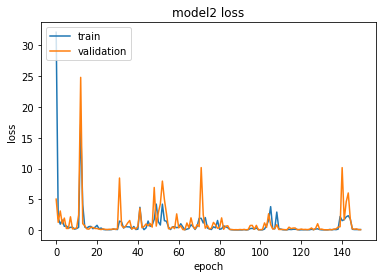

In [31]:
print(history2.history.keys())
# "Loss"
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model2 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [32]:
prediction = estimator.predict(x_test)

146/146 [==============================] - 0s 739us/sample


In [33]:
error =  np.abs(y_test - prediction)
mean_error = np.mean(error)
min_error = np.min(error)
max_error = np.max(error)
std_error = np.std(error)

In [34]:
print("mean error=",mean_error)

mean error= 0.13939277544134046


In [35]:
error=0
for i in range(0,len(prediction)):
    error+=abs((y_testarr[i]-prediction[i])/y_testarr[i]) * 100
error=error/146
print("accuracy=",100-error)

accuracy= 98.83893840617066


# MODEL 3

In [36]:
model3 = Sequential()
model3.add(Dense(128, input_dim=x_train.shape[1], kernel_initializer='normal', activation='relu'))
model3.add(Dense(128, activation='relu'))
model3.add(Dense(32, activation='relu'))
model3.add(Dense(16, activation='relu'))
model3.add(Dense(1, activation='linear'))
model3.summary()
model3.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 128)               33664     
_________________________________________________________________
dense_7 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_8 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_9 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 17        
Total params: 54,849
Trainable params: 54,849
Non-trainable params: 0
_________________________________________________________________


In [37]:
history3 = model3.fit(x_train, y_train, epochs=150, batch_size=32,  verbose=1, validation_split=0.2)

Train on 1051 samples, validate on 263 samples
Epoch 1/150
1051/1051 [==============================] - 2s 2ms/sample - loss: 359.2553 - mean_squared_error: 359.2552 - mean_absolute_error: 8.5165 - val_loss: 17.8912 - val_mean_squared_error: 17.8912 - val_mean_absolute_error: 2.7732
Epoch 2/150
1051/1051 [==============================] - 0s 344us/sample - loss: 13.2827 - mean_squared_error: 13.2827 - mean_absolute_error: 2.2028 - val_loss: 4.9272 - val_mean_squared_error: 4.9272 - val_mean_absolute_error: 1.4869
Epoch 3/150
1051/1051 [==============================] - 0s 350us/sample - loss: 2.5344 - mean_squared_error: 2.5344 - mean_absolute_error: 1.1136 - val_loss: 2.5369 - val_mean_squared_error: 2.5369 - val_mean_absolute_error: 1.1991
Epoch 4/150
1051/1051 [==============================] - 0s 341us/sample - loss: 1.9141 - mean_squared_error: 1.9141 - mean_absolute_error: 0.9558 - val_loss: 5.7301 - val_mean_squared_error: 5.7301 - val_mean_absolute_error: 1.2870
Epoch 5/150
105

Epoch 36/150
1051/1051 [==============================] - 0s 132us/sample - loss: 0.0955 - mean_squared_error: 0.0955 - mean_absolute_error: 0.2166 - val_loss: 0.1067 - val_mean_squared_error: 0.1067 - val_mean_absolute_error: 0.2152
Epoch 37/150
1051/1051 [==============================] - 0s 135us/sample - loss: 0.1500 - mean_squared_error: 0.1500 - mean_absolute_error: 0.2575 - val_loss: 0.5780 - val_mean_squared_error: 0.5780 - val_mean_absolute_error: 0.6720
Epoch 38/150
1051/1051 [==============================] - 0s 127us/sample - loss: 0.2027 - mean_squared_error: 0.2027 - mean_absolute_error: 0.3039 - val_loss: 0.1687 - val_mean_squared_error: 0.1687 - val_mean_absolute_error: 0.2607
Epoch 39/150
1051/1051 [==============================] - 0s 118us/sample - loss: 0.1451 - mean_squared_error: 0.1451 - mean_absolute_error: 0.2628 - val_loss: 2.2832 - val_mean_squared_error: 2.2832 - val_mean_absolute_error: 0.9661
Epoch 40/150
1051/1051 [==============================] - 0s 113

1051/1051 [==============================] - 0s 133us/sample - loss: 0.4101 - mean_squared_error: 0.4101 - mean_absolute_error: 0.4442 - val_loss: 0.1401 - val_mean_squared_error: 0.1401 - val_mean_absolute_error: 0.2323
Epoch 72/150
1051/1051 [==============================] - 0s 130us/sample - loss: 0.4618 - mean_squared_error: 0.4618 - mean_absolute_error: 0.4260 - val_loss: 2.6781 - val_mean_squared_error: 2.6781 - val_mean_absolute_error: 0.4717
Epoch 73/150
1051/1051 [==============================] - 0s 111us/sample - loss: 0.3364 - mean_squared_error: 0.3364 - mean_absolute_error: 0.3640 - val_loss: 0.3136 - val_mean_squared_error: 0.3136 - val_mean_absolute_error: 0.3333
Epoch 74/150
1051/1051 [==============================] - 0s 113us/sample - loss: 0.5662 - mean_squared_error: 0.5662 - mean_absolute_error: 0.4506 - val_loss: 4.6534 - val_mean_squared_error: 4.6534 - val_mean_absolute_error: 1.9602
Epoch 75/150
1051/1051 [==============================] - 0s 130us/sample - l

1051/1051 [==============================] - 0s 129us/sample - loss: 0.3044 - mean_squared_error: 0.3044 - mean_absolute_error: 0.3857 - val_loss: 0.2854 - val_mean_squared_error: 0.2854 - val_mean_absolute_error: 0.3804
Epoch 107/150
1051/1051 [==============================] - 0s 112us/sample - loss: 0.1581 - mean_squared_error: 0.1581 - mean_absolute_error: 0.2930 - val_loss: 0.2474 - val_mean_squared_error: 0.2474 - val_mean_absolute_error: 0.2534
Epoch 108/150
1051/1051 [==============================] - 0s 112us/sample - loss: 0.2559 - mean_squared_error: 0.2559 - mean_absolute_error: 0.3593 - val_loss: 0.2608 - val_mean_squared_error: 0.2608 - val_mean_absolute_error: 0.4675
Epoch 109/150
1051/1051 [==============================] - 0s 112us/sample - loss: 0.1006 - mean_squared_error: 0.1006 - mean_absolute_error: 0.2367 - val_loss: 0.0604 - val_mean_squared_error: 0.0604 - val_mean_absolute_error: 0.1658
Epoch 110/150
1051/1051 [==============================] - 0s 119us/sample

Epoch 141/150
1051/1051 [==============================] - 0s 132us/sample - loss: 0.1735 - mean_squared_error: 0.1735 - mean_absolute_error: 0.2561 - val_loss: 0.2477 - val_mean_squared_error: 0.2477 - val_mean_absolute_error: 0.2719
Epoch 142/150
1051/1051 [==============================] - 0s 120us/sample - loss: 0.7478 - mean_squared_error: 0.7478 - mean_absolute_error: 0.5983 - val_loss: 0.6355 - val_mean_squared_error: 0.6355 - val_mean_absolute_error: 0.3644
Epoch 143/150
1051/1051 [==============================] - 0s 113us/sample - loss: 0.4218 - mean_squared_error: 0.4218 - mean_absolute_error: 0.4300 - val_loss: 0.5405 - val_mean_squared_error: 0.5405 - val_mean_absolute_error: 0.4243
Epoch 144/150
1051/1051 [==============================] - 0s 127us/sample - loss: 0.5272 - mean_squared_error: 0.5272 - mean_absolute_error: 0.5161 - val_loss: 1.9416 - val_mean_squared_error: 1.9416 - val_mean_absolute_error: 0.8489
Epoch 145/150
1051/1051 [==============================] - 0

dict_keys(['loss', 'mean_squared_error', 'mean_absolute_error', 'val_loss', 'val_mean_squared_error', 'val_mean_absolute_error'])


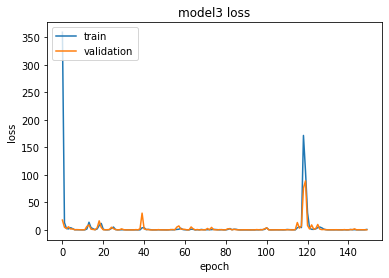

In [38]:
print(history3.history.keys())
# "Loss"
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('model3 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [39]:
ypred3=model3.predict(x_test)

In [40]:
error=0
for i in range(0,len(ypred3)):
    error+=abs((y_testarr[i]-ypred3[i])/y_testarr[i]) * 100
error=error/146
print("accuracy=",100-error)

accuracy= [96.99355]


In [41]:
error =  np.abs(y_test - prediction)
mean_error = np.mean(error)
min_error = np.min(error)
max_error = np.max(error)
std_error = np.std(error)

In [42]:
print("mean error=",mean_error)

mean error= 0.13939277544134046
